# Creating a Two Step Model

- The first model will help decide whether the driver will be active/ online on a particular day or not
- The second model will further score the number of hours the driver will be online in case the first model says that the driver will be active

# 1. Classification Model

***
-Binary Classification Model for deciding whether the driver will be active on a particular day or not
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn.model_selection import learning_curve, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
import graphviz 
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
train = pd.read_parquet('train_data.parquet', engine='fastparquet')
test = pd.read_parquet('test_data.parquet', engine='fastparquet')

train['Ind'] = 'Train'
test['Ind'] = 'Test'
train["online_hours"] = train["online_hours"].astype(int)

kid_weekday = (train.groupby(['number_of_kids', 'weekday'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
kid_weekday.columns = ['number_of_kids', 'weekday', 'Avg_kid_weekday_online_hours']
kid_age = (train.groupby(['number_of_kids', 'age_bucket'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
kid_age.columns = ['number_of_kids', 'age_bucket', 'Avg_kid_age_online_hours']
age_weekday = (train.groupby(['weekday', 'age_bucket'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
age_weekday.columns = ['weekday', 'age_bucket', 'Avg_weekday_age_online_hours']

train = pd.merge(train, kid_weekday, on = ['number_of_kids', 'weekday'], how = 'left')
train = pd.merge(train, kid_age, on = ['number_of_kids', 'age_bucket'], how = 'left')
train = pd.merge(train, age_weekday, on = ['weekday', 'age_bucket'], how = 'left')

test = pd.merge(test, kid_weekday, on = ['number_of_kids', 'weekday'], how = 'left')
test = pd.merge(test, kid_age, on = ['number_of_kids', 'age_bucket'], how = 'left')
test = pd.merge(test, age_weekday, on = ['weekday', 'age_bucket'], how = 'left')

### Joining Train and Test data set for Processing together
df =  pd.concat(objs=[train, test], axis=0, sort=True).reset_index(drop=True)

df.head()


/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,age_bucket,date,driver_id,gender,number_of_kids,online_hours,weekday,weekend_flag
0,6.155402,6.342803,5.651890,Train,49,2,2017-06-01,111556,FEMALE,4,2,3,0
1,6.155402,7.010417,6.301718,Train,49,2,2017-06-02,111556,FEMALE,4,2,4,0
2,6.155402,4.850379,4.350859,Train,49,2,2017-06-03,111556,FEMALE,4,0,5,1
3,6.155402,5.326705,4.501031,Train,49,2,2017-06-04,111556,FEMALE,4,0,6,1
4,6.155402,6.623106,5.990378,Train,49,2,2017-06-05,111556,FEMALE,4,5,0,0


### Creating the Binary Indicator for Online

In [4]:
df['online'] = 0
df.loc[df['online_hours'] > 0, 'online'] = 1

### Convert categorical variables into pandas category

In [5]:
## Creating dummies using pandas for categorical variables
df.reset_index(drop = True, inplace= True)

dummies_gender = pd.get_dummies(df.gender)
df = df.join(dummies_gender)

dummies_weekday = pd.get_dummies(df.weekday, prefix= 'weekday', prefix_sep= '_')
df = df.join(dummies_weekday)

dummies_weekend_flag = pd.get_dummies(df.weekend_flag, prefix= 'weekend_flag', prefix_sep= '_')
df = df.join(dummies_weekend_flag)

dummies_age_bucket = pd.get_dummies(df.age_bucket, prefix= 'age_bucket', prefix_sep= '_')
df = df.join(dummies_age_bucket)

#Drop name & age columns
df.drop(['date','online_hours', 'driver_id', 'gender', 'weekday', 'weekend_flag', 'age_bucket'], axis=1, inplace=True)
df.head()

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,number_of_kids,online,FEMALE,MALE,weekday_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend_flag_0,weekend_flag_1,age_bucket_1,age_bucket_2,age_bucket_3
0,6.155402,6.342803,5.651890,Train,49,4,1,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,6.155402,7.010417,6.301718,Train,49,4,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
2,6.155402,4.850379,4.350859,Train,49,4,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
3,6.155402,5.326705,4.501031,Train,49,4,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
4,6.155402,6.623106,5.990378,Train,49,4,1,1,0,1,...,0,0,0,0,0,1,0,0,1,0


### Separate train dataset and test dataset

In [6]:
train = df[df['Ind'] == 'Train']
test = df[df['Ind'] == 'Test']
#test.drop(["online"],axis = 1,inplace=True)
train.shape
test.shape

(52080, 21)

(17500, 21)

In [7]:
# Separate train features and label 
train["online"] = train["online"].astype(int)
y = train["online"]
df = train.drop(["online", 'Ind'],axis = 1)
df.head()

/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,age,number_of_kids,FEMALE,MALE,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend_flag_0,weekend_flag_1,age_bucket_1,age_bucket_2,age_bucket_3
0,6.155402,6.342803,5.651890,49,4,1,0,0,0,0,1,0,0,0,1,0,0,1,0
1,6.155402,7.010417,6.301718,49,4,1,0,0,0,0,0,1,0,0,1,0,0,1,0
2,6.155402,4.850379,4.350859,49,4,1,0,0,0,0,0,0,1,0,0,1,0,1,0
3,6.155402,5.326705,4.501031,49,4,1,0,0,0,0,0,0,0,1,0,1,0,1,0
4,6.155402,6.623106,5.990378,49,4,1,0,1,0,0,0,0,0,0,1,0,0,1,0


## Random Forest Model for Classification

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2)

print('Training set: %s, %s' %(X_train.shape, y_train.shape))
print('Validation set: %s, %s' %(X_val.shape, y_val.shape))

m = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 5, max_depth=3, n_jobs = -1, oob_score=True)
m.fit(X_train, y_train)

Training set: (41664, 19), (41664,)
Validation set: (10416, 19), (10416,)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [9]:
m.score(X_train, y_train)

m.score(X_val, y_val)

0.8315812211981567

0.8358294930875576

In [10]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

rf_feat_importance(m, X_train)

,cols,imp
1,Avg_kid_weekday_online_hours,0.215409
15,weekend_flag_1,0.202930
14,weekend_flag_0,0.202159
2,Avg_weekday_age_online_hours,0.187743
13,weekday_6,0.062134
5,FEMALE,0.037864
6,MALE,0.037503
12,weekday_5,0.032793
9,weekday_2,0.004802
8,weekday_1,0.004332


### Scoring the Test Population

In [11]:
y_test = test['online']
test.drop([ 'Ind','online'], axis=1, inplace=True)

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: 'Not Online', 1: 'Online'}

Accuracy of Random Forest Classifier on training data: 0.83
Accuracy of Random Forest Classifier on testing data: 0.82


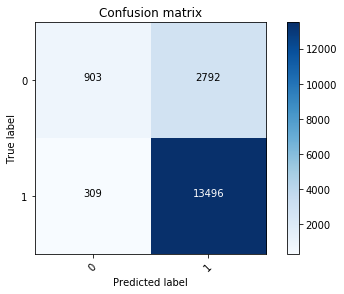

In [13]:
print('Accuracy of Random Forest Classifier on training data: {:.2f}'.format(m.score(X_train,y_train)))
print('Accuracy of Random Forest Classifier on testing data: {:.2f}'.format(m.score(test,y_test)))
model = m
prediction = model.predict(test)
cnf_matrix = confusion_matrix(y_test, prediction)
plt.show()

plot_confusion_matrix(cnf_matrix, classes=dict_characters,title='Confusion matrix')
plt.show()

Text(0.5,1,'Precision-Recall vs Threshold Chart')

Text(0,0.5,'Precision, Recall')

Text(0.5,0,'Threshold')

(0, 1)

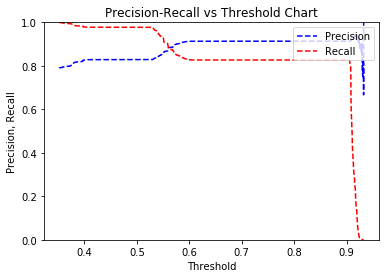

In [14]:
probs_y=m.predict_proba(test)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 
   #retrieve probability of being 1(in second column of probs_y)


pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper right")
plt.ylim([0,1])

In [15]:
import pickle
pickle.dump(model, open("rf_model_classification.pickle", "wb"))

# 2. Regression Model

***
-Regression Model to score the ones which have been classified as Online/ Active days for Drivers
***

In [16]:
train = pd.read_parquet('train_data.parquet', engine='fastparquet')
test = pd.read_parquet('test_data.parquet', engine='fastparquet')
train = train[train['online_hours'] < 24]
train['Ind'] = 'Train'
test['Ind'] = 'Test'
train["online_hours"] = train["online_hours"].astype(int)

kid_weekday = (train.groupby(['number_of_kids', 'weekday'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
kid_weekday.columns = ['number_of_kids', 'weekday', 'Avg_kid_weekday_online_hours']
kid_age = (train.groupby(['number_of_kids', 'age_bucket'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
kid_age.columns = ['number_of_kids', 'age_bucket', 'Avg_kid_age_online_hours']
age_weekday = (train.groupby(['weekday', 'age_bucket'])[['online_hours']].apply(lambda x: x.mean())).reset_index()
age_weekday.columns = ['weekday', 'age_bucket', 'Avg_weekday_age_online_hours']

train = pd.merge(train, kid_weekday, on = ['number_of_kids', 'weekday'], how = 'left')
train = pd.merge(train, kid_age, on = ['number_of_kids', 'age_bucket'], how = 'left')
train = pd.merge(train, age_weekday, on = ['weekday', 'age_bucket'], how = 'left')

test = pd.merge(test, kid_weekday, on = ['number_of_kids', 'weekday'], how = 'left')
test = pd.merge(test, kid_age, on = ['number_of_kids', 'age_bucket'], how = 'left')
test = pd.merge(test, age_weekday, on = ['weekday', 'age_bucket'], how = 'left')

### Joining Train and Test data set for Processing together
df =  pd.concat(objs=[train, test], axis=0, sort=True).reset_index(drop=True)

df.head()

/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,age_bucket,date,driver_id,gender,number_of_kids,online_hours,weekday,weekend_flag
0,4.232275,4.816872,4.326824,Train,49,2,2017-06-01,111556,FEMALE,4,2,3,0
1,4.232275,4.913830,4.410042,Train,49,2,2017-06-02,111556,FEMALE,4,2,4,0
2,4.232275,3.259487,2.846097,Train,49,2,2017-06-03,111556,FEMALE,4,0,5,1
3,4.232275,3.416493,2.811800,Train,49,2,2017-06-04,111556,FEMALE,4,0,6,1
4,4.232275,4.984456,4.611173,Train,49,2,2017-06-05,111556,FEMALE,4,5,0,0


In [17]:
## Creating dummies using pandas for categorical variables
df.reset_index(drop = True, inplace= True)

dummies_gender = pd.get_dummies(df.gender)
df = df.join(dummies_gender)

dummies_weekday = pd.get_dummies(df.weekday, prefix= 'weekday', prefix_sep= '_')
df = df.join(dummies_weekday)

dummies_weekend_flag = pd.get_dummies(df.weekend_flag, prefix= 'weekend_flag', prefix_sep= '_')
df = df.join(dummies_weekend_flag)

dummies_age_bucket = pd.get_dummies(df.age_bucket, prefix= 'age_bucket', prefix_sep= '_')
df = df.join(dummies_age_bucket)
df.head()

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,age_bucket,date,driver_id,gender,number_of_kids,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend_flag_0,weekend_flag_1,age_bucket_1,age_bucket_2,age_bucket_3
0,4.232275,4.816872,4.326824,Train,49,2,2017-06-01,111556,FEMALE,4,...,0,1,0,0,0,1,0,0,1,0
1,4.232275,4.913830,4.410042,Train,49,2,2017-06-02,111556,FEMALE,4,...,0,0,1,0,0,1,0,0,1,0
2,4.232275,3.259487,2.846097,Train,49,2,2017-06-03,111556,FEMALE,4,...,0,0,0,1,0,0,1,0,1,0
3,4.232275,3.416493,2.811800,Train,49,2,2017-06-04,111556,FEMALE,4,...,0,0,0,0,1,0,1,0,1,0
4,4.232275,4.984456,4.611173,Train,49,2,2017-06-05,111556,FEMALE,4,...,0,0,0,0,0,1,0,0,1,0


In [18]:
#Drop name & age columns
df.drop(['date','age_bucket','weekend_flag','weekday','gender','driver_id'], axis=1, inplace=True)
df.head()

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,number_of_kids,online_hours,FEMALE,MALE,weekday_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend_flag_0,weekend_flag_1,age_bucket_1,age_bucket_2,age_bucket_3
0,4.232275,4.816872,4.326824,Train,49,4,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,4.232275,4.913830,4.410042,Train,49,4,2,1,0,0,...,0,0,1,0,0,1,0,0,1,0
2,4.232275,3.259487,2.846097,Train,49,4,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
3,4.232275,3.416493,2.811800,Train,49,4,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
4,4.232275,4.984456,4.611173,Train,49,4,5,1,0,1,...,0,0,0,0,0,1,0,0,1,0


### Splitting Test and Train

In [29]:
train = df[df['Ind'] == 'Train']
test = df[df['Ind'] == 'Test']
#test.drop(["online"],axis = 1,inplace=True)
train.shape
test.shape

(47884, 21)

(17500, 21)

In [20]:
from sklearn.ensemble import RandomForestRegressor
# Establish model

from sklearn.model_selection import train_test_split
y = train["online_hours"]
train.drop([ 'Ind','online_hours'], axis=1, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.2)

print('Training set: %s, %s' %(X_train.shape, y_train.shape))
print('Validation set: %s, %s' %(X_val.shape, y_val.shape))

m = RandomForestRegressor(n_estimators = 500, min_samples_leaf = 5, max_depth=6, n_jobs = -1, oob_score=True)
m.fit(X_train, y_train)

/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Training set: (38307, 19), (38307,)
Validation set: (9577, 19), (9577,)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [21]:
from sklearn import metrics
predictions = m.predict(X_train)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))

Mean Absolute Error: 2.5906173555696914
Mean Squared Error: 9.592577401381527
Root Mean Squared Error: 3.097188628640743


In [22]:
from sklearn import metrics
predictions = m.predict(X_val)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_val, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, predictions)))

Mean Absolute Error: 2.6119215073750293
Mean Squared Error: 9.765958049698988
Root Mean Squared Error: 3.1250532874975088


In [23]:
pickle.dump(m, open("rf_model_regression.pickle", "wb"))

# Scoring the Test Data to calculate the overall RMSE

In [30]:
test.head()

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,Ind,age,number_of_kids,online_hours,FEMALE,MALE,weekday_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend_flag_0,weekend_flag_1,age_bucket_1,age_bucket_2,age_bucket_3
47884,4.232275,4.816872,4.326824,Test,49,4,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
47885,4.232275,4.913830,4.410042,Test,49,4,5,1,0,0,...,0,0,1,0,0,1,0,0,1,0
47886,4.232275,3.259487,2.846097,Test,49,4,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
47887,4.232275,3.416493,2.811800,Test,49,4,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
47888,4.232275,4.984456,4.611173,Test,49,4,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0


In [31]:
y = test['online_hours']
test.drop(['Ind', 'online_hours'],  axis=1, inplace=True)
test.head()

/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,age,number_of_kids,FEMALE,MALE,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekend_flag_0,weekend_flag_1,age_bucket_1,age_bucket_2,age_bucket_3
47884,4.232275,4.816872,4.326824,49,4,1,0,0,0,0,1,0,0,0,1,0,0,1,0
47885,4.232275,4.913830,4.410042,49,4,1,0,0,0,0,0,1,0,0,1,0,0,1,0
47886,4.232275,3.259487,2.846097,49,4,1,0,0,0,0,0,0,1,0,0,1,0,1,0
47887,4.232275,3.416493,2.811800,49,4,1,0,0,0,0,0,0,0,1,0,1,0,1,0
47888,4.232275,4.984456,4.611173,49,4,1,0,1,0,0,0,0,0,0,1,0,0,1,0


In [32]:
pred1 = model.predict(test)
pred2 = m.predict(test)
test['Class_pred'] = pred1
test['Reg_pred'] = pred2
test['online_hours'] = y
test.head()

/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,Avg_kid_age_online_hours,Avg_kid_weekday_online_hours,Avg_weekday_age_online_hours,age,number_of_kids,FEMALE,MALE,weekday_0,weekday_1,weekday_2,...,weekday_5,weekday_6,weekend_flag_0,weekend_flag_1,age_bucket_1,age_bucket_2,age_bucket_3,Class_pred,Reg_pred,online_hours
47884,4.232275,4.816872,4.326824,49,4,1,0,0,0,0,...,0,0,1,0,0,1,0,1,3.582883,2
47885,4.232275,4.913830,4.410042,49,4,1,0,0,0,0,...,0,0,1,0,0,1,0,1,3.598990,5
47886,4.232275,3.259487,2.846097,49,4,1,0,0,0,0,...,1,0,0,1,0,1,0,0,0.931354,0
47887,4.232275,3.416493,2.811800,49,4,1,0,0,0,0,...,0,1,0,1,0,1,0,0,0.921541,0
47888,4.232275,4.984456,4.611173,49,4,1,0,1,0,0,...,0,0,1,0,0,1,0,1,3.582319,0


In [33]:
test.loc[test['Class_pred'] == 0, 'Reg_pred'] = 0

/home/jovyan/.conda/envs/pycp_py3k/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
y_train = test['Reg_pred']
predictions = test['online_hours']
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, predictions)))

Mean Absolute Error: 2.6378858022291993
Mean Squared Error: 9.914216044883034
Root Mean Squared Error: 3.1486848119306945
